# Logistic Regression - One Vs All Classification

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set figure style
plt.style.use('seaborn-whitegrid')
# random seed for reproducibility
np.random.seed(101)

## One Vs All Classification
Logistic Regression, as we saw in the notebook named `Logistic Regression - Binary Classification` is a binary classifier which can be used to differentiate between two categories of data points. However, In real life scenerio's, we often need to classy things in one of the many categories available.

To do this with logistic regression, we a strategy called as **One Vs All**. According to this strategy, we are going to create `N` logistic classifiers for `N` classes of data available. Each classifier will have the task of classifying the data point as either belonging to the class it is meant to find or to rest of the classes which are not the responsibility of that classifier. The classifier, that gives most positive or `1 as output` dictates the class that the data point belong to. The following images visualizes the process.

<img src="./imgs/onevall.png" width = "512" height = "512" />

In multi-class classification, each line in the above image belong to a seperate logistic classifier whose responsibility is to classify the same colored class from the others.

## Flower Species Classification
Let's assume that you are a flower enthusiast, who would like to differentiate between 3 classes of flowers namely,
- Iris Setosa
- Iris Versicolour
- Iris Virginica

To do so, you have 4 features of 150 flowers namely,
- sepal length in cm
- sepal width in cm
- petal length in cm
- petal width in cm 

Let's load the dataset and start preparing it for One vs All Classification

In [2]:
# load dataset
from sklearn.datasets import load_iris

iris = load_iris()

# create dataframe and create empty taget columns
df = pd.DataFrame(data = iris.data, columns=iris.feature_names)
df['target'] = iris.target
df['class1'] = np.zeros_like(iris.target)
df['class2'] = np.zeros_like(iris.target)
df['class3'] = np.zeros_like(iris.target)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,class1,class2,class3
0,5.1,3.5,1.4,0.2,0,0,0,0
1,4.9,3.0,1.4,0.2,0,0,0,0
2,4.7,3.2,1.3,0.2,0,0,0,0
3,4.6,3.1,1.5,0.2,0,0,0,0
4,5.0,3.6,1.4,0.2,0,0,0,0


In [3]:
# get indices of examples belonging to each class
class_1_index = df[df.target == 0].index
class_2_index = df[df.target == 1].index
class_3_index = df[df.target == 2].index

# populate columns created earlier to reflect classification target for 
# each Logistic classifier
df.loc[class_1_index, "class1"] = 1
df.loc[class_2_index, "class2"] = 1
df.loc[class_3_index, "class3"] = 1

df = df.sample(frac=1)

As before, we are going to use the advanced optimization technique, known as L-BFGS. To do so we have the following necessary functions.
- **Sigmoid** : Apply Sigmoid activation to output
- **logits** : Calculate output by multiplying weights
- **probability** : Calculate output probabilities
- **cost_function** : Calculate the loss/cost during training
- **gradient** : Calculates the gradients during training

In [4]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Calculate Logits
def logits(weights, x):
    return np.dot(x, weights)

# Calculate probabilities
def probability(weights, x):
    return sigmoid(logits(weights, x))

def cost_function(weights, x, y, epsilon = 1e-12):
    m = x.shape[0]
    y_hat = probability(weights, x)
    cost = -y * np.log(y_hat + epsilon) - (1 - y) * np.log(1 - y_hat + epsilon)
    cost = (1 / m) * np.sum(cost)
    return cost

def gradient(weights, x, y):
    grad = (1 / x.shape[0]) * np.matmul(x.T, probability(weights, x) - y)
    return grad.flatten()

Creating eassential variables

In [5]:
# preparing input feature matrix
x_values = df[iris.feature_names].values

X = np.ones((x_values.shape[0], x_values.shape[1] + 1))
X[:, 1:] = x_values

# preparing targets for each classifier
all_targets = []
target_names = ["class1", "class2", "class3"]

for cls in target_names:
    y_values = df[cls].values
    y_values = np.reshape(y_values, (-1, 1))
    all_targets.append(y_values)

# randomly initializing weights for each classifier
all_theta = []
for i in range(len(target_names)):
    theta = np.random.rand(X.shape[1], 1)
    all_theta.append(theta)

### Let's Start Training

In [6]:
from scipy.optimize import fmin_cg
# training
optimized_params = []

for target, theta in zip(all_targets, all_theta):
    optimized_params.append(fmin_cg(cost_function, theta, gradient, args=(X, target.flatten()), disp=True))

print("Optimized parameters : ")
for i, params in enumerate(optimized_params):
    print("Parameters for cls {} and rest {}".format(i + 1, params))

Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 14
         Function evaluations: 61
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: 0.483566
         Iterations: 83
         Function evaluations: 196
         Gradient evaluations: 196
Optimization terminated successfully.
         Current function value: 0.039666
         Iterations: 953
         Function evaluations: 2409
         Gradient evaluations: 2409
Optimized parameters : 
Parameters for cls 1 and rest [ 1.6262538   1.70350303  5.96630073 -9.61207693 -3.9698846 ]
Parameters for cls 2 and rest [ 7.37618753 -0.24551263 -2.79565687  1.31373635 -2.77821455]
Parameters for cls 3 and rest [-43.52428519  -2.46142415  -6.76440785   9.56418883  18.54578726]


## Evaluation
Now that the training is complete, its time to see how well our classifiers performed. We will first calculate probablities based on the weights we obtained and then use metrics like precision, recall , f1-score and accuracy to evaluate the model.

**NOTE** : This step is done on Validation set, set of data points not seen by model during training, But as size of dataset is small, I am doing this on Training set.

In [7]:
# calculate probabilities
c1 = probability(optimized_params[0], X)
c2 = probability(optimized_params[1], X)
c3 = probability(optimized_params[2], X)

pred = []
for probs in zip(c1, c2, c3):
    pred.append(np.argmax(probs))

In [8]:
from sklearn.metrics import classification_report
# get classification report
print(classification_report(df['target'].values, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.96      0.97        50
           2       0.96      0.98      0.97        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



Wow we got 98% accuracy on **Training Set**, this means our models have a very good idea of what datapoints belong to what class. This model may not work this good in production for the purpose of demonstration, it is outstanding.

Now lets calculate and plot decision boundary of each class.

In [9]:
# decision boundary calculation
means = np.mean(X, axis=0)

features = X
features[:, 1] = means[1]
features[:, 2] = means[2]

c1 = optimized_params[0]
c2 = optimized_params[1]
c3 = optimized_params[2]

val = np.array([min(features[:, 3]), max(features[:, 3])])

x2_1 = -(c1[0] + c1[1] * means[1] + c1[2] * means[2] + c1[3] * val) / c1[4]
x2_2 = -(c2[0] + c2[1] * means[1] + c2[2] * means[2] + c2[3] * val) / c2[4]
x2_3 = -(c3[0] + c3[1] * means[1] + c3[2] * means[2] + c3[3] * val) / c3[4]

<IPython.core.display.Javascript object>


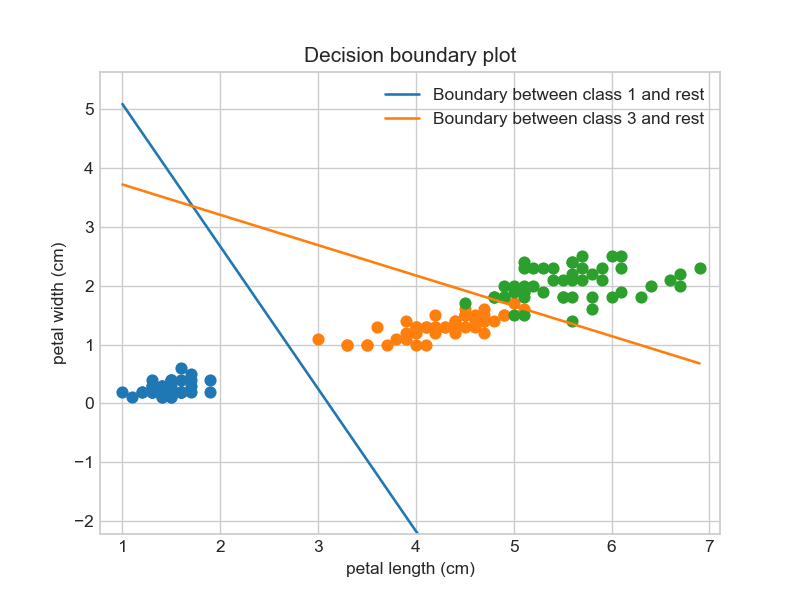

In [10]:
%matplotlib notebook
# Ploting boundary
plt.scatter(df[df.target == 0]["petal length (cm)"], df[df.target == 0]["petal width (cm)"])
plt.scatter(df[df.target == 1]["petal length (cm)"], df[df.target == 1]["petal width (cm)"])
plt.scatter(df[df.target == 2]["petal length (cm)"], df[df.target == 2]["petal width (cm)"])
plt.plot(val, x2_1, label="Boundary between class 1 and rest")
plt.plot(val, x2_3, label="Boundary between class 3 and rest")
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.title("Decision boundary plot")
plt.legend()

## References
- One vs All : https://www.ritchieng.com/logistic-regression/